In [63]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos
data = pd.read_csv('Wind_Data.csv')
data.head()


,dia,regional wind,wind gap norte sur
0,1,8.000000,0.000000
1,2,8.346296,0.181523
2,3,10.062316,0.188643
3,4,10.791337,0.071085
4,5,10.754093,0.078442


In [64]:
def daily_dif(current_wind, previous_wind):
    # Calcular el incremento como la diferencia entre los vientos
    return (current_wind - previous_wind)

# Calcular incremento diario
data['wind_increase'] = daily_dif(data['regional wind'], data['regional wind'].shift(1))
data.head()


,dia,regional wind,wind gap norte sur,wind_increase
0,1,8.000000,0.000000,NaN
1,2,8.346296,0.181523,0.346296
2,3,10.062316,0.188643,1.716019
3,4,10.791337,0.071085,0.729021
4,5,10.754093,0.078442,-0.037244


In [65]:
# Definir delta
delta = 1/365

# Definir la θ(t)
def theta(i):
    return 6 + 2 * math.cos(2*math.pi * (i-1)/365)

# Calcular θ(t) para cada día
data['theta'] = data['dia'].apply(theta)
data.head()


,dia,regional wind,wind gap norte sur,wind_increase,theta
0,1,8.000000,0.000000,NaN,8.000000
1,2,8.346296,0.181523,0.346296,7.999704
2,3,10.062316,0.188643,1.716019,7.998815
3,4,10.791337,0.071085,0.729021,7.997334
4,5,10.754093,0.078442,-0.037244,7.995261


# Ejercicio 1
Estimamos los parámetros 


In [66]:
s_i = data['regional wind'].shift(1)
theta = data['theta']
X = ((theta - s_i) * delta)[1:].values
Y = (data['wind_increase'])[1:].values

# Modelo de regresión lineal
reg = LinearRegression().fit(X.reshape(-1, 1), Y)

# Predicciones y error
Y_pred = reg.predict(X.reshape(-1, 1))
error = Y - Y_pred

# Cálculo de kappa y sigma con error de estimación
kappa = reg.coef_[0]
c = np.sqrt(error.var())
sigma = c / np.sqrt(delta)

# Error estándar de σ
sigma_error = sigma / np.sqrt(2 * len(error))

# Error estándar de kappa
kappa_error = np.sqrt(np.sum((error - np.mean(error))**2) / (len(error) - 2)) / np.sqrt(np.sum(X**2))

print(f"κ: {kappa}, Error de κ: {kappa_error}")
print(f"σ: {sigma}, Error de σ: {sigma_error}")



κ: 109.04125628331572, Error de κ: 4.294413913397189
σ: 16.04457314539312, Error de σ: 0.18781325432638485


In [67]:
# Creamos 'gap_dif' como la diferencia diaria del gap del viento entre el norte y sur
data['gap_dif'] = data['wind gap norte sur'] - data['wind gap norte sur'].shift(1)
data.head()

# Definimos variables para wind gap
Y_gap = (data['gap_dif'])[1:].values
d_i = data['wind gap norte sur'].shift(1)
X_gap = (d_i * delta)[1:].values

# Ajustar el modelo de regresión lineal para el wind gap
reg_gap = LinearRegression().fit(X_gap.reshape(-1, 1), Y_gap)

# Predecimos y calculamos error
Y_pred_gap = reg_gap.predict(X_gap.reshape(-1, 1))
error_gap = Y_gap - Y_pred_gap

# Cálculo de beta y gamma y su error de estimación
beta = -(reg_gap.coef_[0])
gamma = np.sqrt(error_gap.var()) / np.sqrt(delta)

# Error estándar de gamma
gamma_error = gamma / np.sqrt(len(error_gap))

# Error estándar de beta
beta_error = np.sqrt(np.sum((error_gap - np.mean(error_gap))**2) / (len(error_gap) - 2)) / np.sqrt(np.sum(X_gap**2))

print(f"β: {beta}, Error de β: {beta_error}")
print(f"γ: {gamma}, Error de γ: {gamma_error}")

β: 48.37733323194379, Error de β: 3.0057533121947224
γ: 10.090719957138331, Error de γ: 0.1670456696712918


# Ejercicio 2
Simulamos los molinos en paralelo y graficamos el histórico para compararlos y ver que tan bien esta:

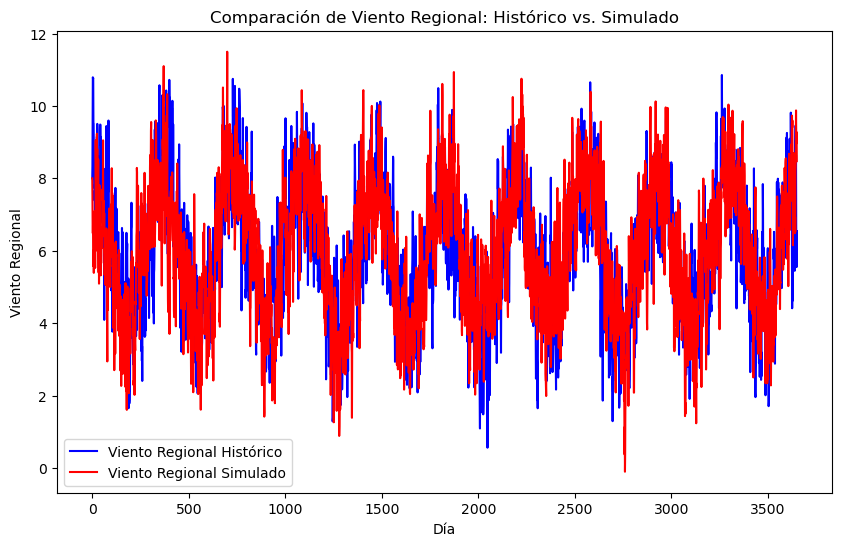

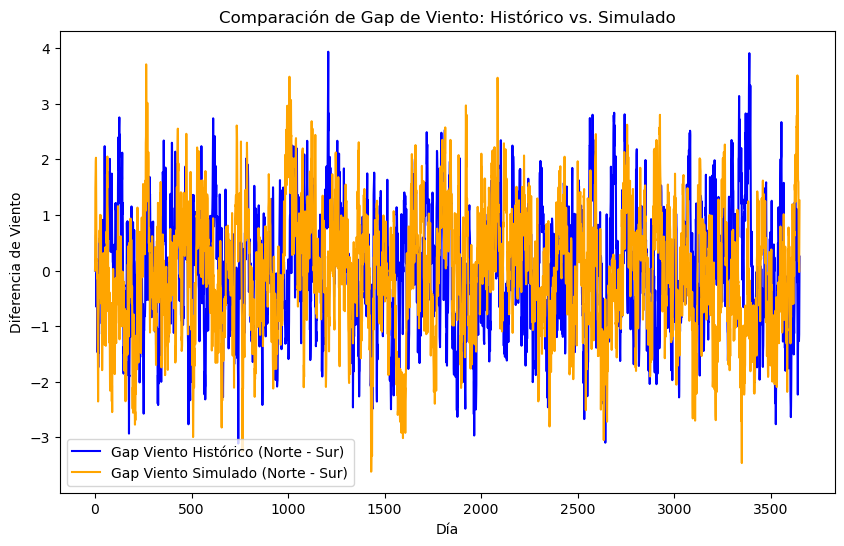

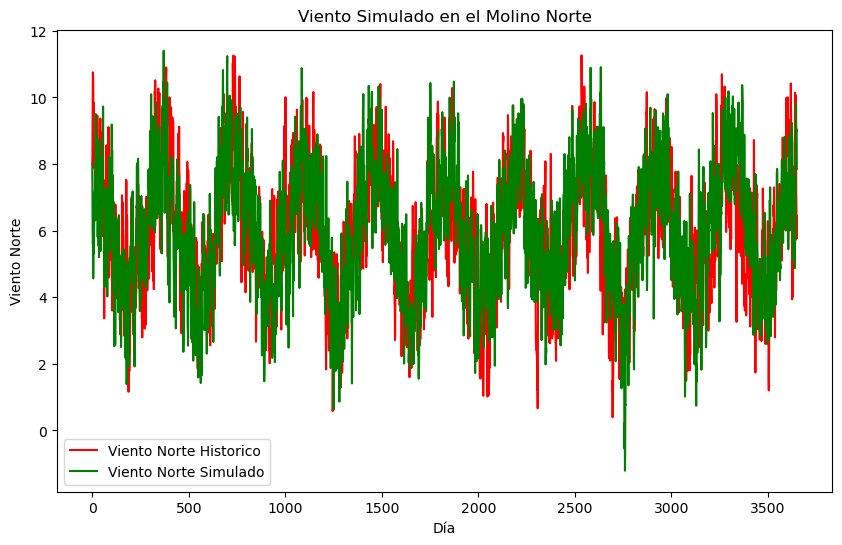

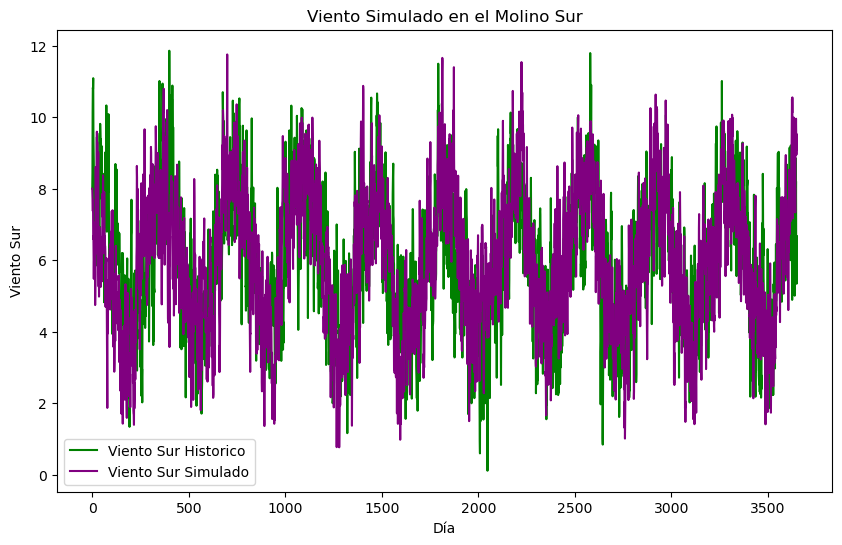

In [68]:
# Función para simular caminos de viento
def wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T):
    S = np.full(T, S_0)
    D = np.full(T, D_0)
    for t in range(1, T):
        Z = np.random.normal(0, 1)  # Shock para el viento regional
        W = np.random.normal(0, 1)  # Shock para la diferencia de viento
            
        # Evolución del viento regional
        S[t] = S[t-1] + kappa * (theta[t] - S[t-1]) * delta + np.sqrt(delta) * Z * sigma
            
        # Evolución de la diferencia de viento entre Norte y Sur
        D[t] = D[t-1] - (beta * D[t-1] * delta) + gamma * np.sqrt(delta) * W

    return S, D

# Inicialización de parámetros
S_0 = data['regional wind'].iloc[0]
D_0 = data['wind gap norte sur'].iloc[0]
T = len(data)  # Usamos el mismo número de días que en los datos históricos
delta = 1 / 365  

# Simulamos
S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)

# Calculamos viento en Norte y Sur
viento_norte = S - D / 2
viento_sur = S + D / 2

#Calculamos viento historico norte y sur
viento_norte_historico = data['regional wind'] - data['wind gap norte sur'] / 2
viento_sur_historico = data['regional wind'] + data['wind gap norte sur'] / 2


# Graficamos el viento regional y simulado
plt.figure(figsize=(10, 6))
plt.plot(data['regional wind'], label='Viento Regional Histórico', color='blue')
plt.plot(S, label='Viento Regional Simulado', color='red')
plt.title('Comparación de Viento Regional: Histórico vs. Simulado')
plt.xlabel('Día')
plt.ylabel('Viento Regional')
plt.legend()
plt.show()

# Graficamos la diferencia de viento (gap) entre Norte y Sur
plt.figure(figsize=(10, 6))
plt.plot(data['wind gap norte sur'], label='Gap Viento Histórico (Norte - Sur)', color='blue')
plt.plot(D, label='Gap Viento Simulado (Norte - Sur)', color='orange')
plt.title('Comparación de Gap de Viento: Histórico vs. Simulado')
plt.xlabel('Día')
plt.ylabel('Diferencia de Viento')
plt.legend()
plt.show()

# Graficamos el viento en el molino Norte
plt.figure(figsize=(10, 6))
plt.plot(viento_norte_historico, label='Viento Norte Historico', color='red')
plt.plot(viento_norte, label='Viento Norte Simulado', color='green')
plt.title('Viento Simulado en el Molino Norte')
plt.xlabel('Día')
plt.ylabel('Viento Norte')
plt.legend()
plt.show()

# Graficamos el viento en el molino Sur
plt.figure(figsize=(10, 6))
plt.plot(viento_sur_historico, label='Viento Sur Historico', color='green')
plt.plot(viento_sur, label='Viento Sur Simulado', color='purple')
plt.title('Viento Simulado en el Molino Sur')
plt.xlabel('Día')
plt.ylabel('Viento Sur')
plt.legend()
plt.show()


Hacemos una función para simular M veces (M = 30) el viento y almacenar en una matriz

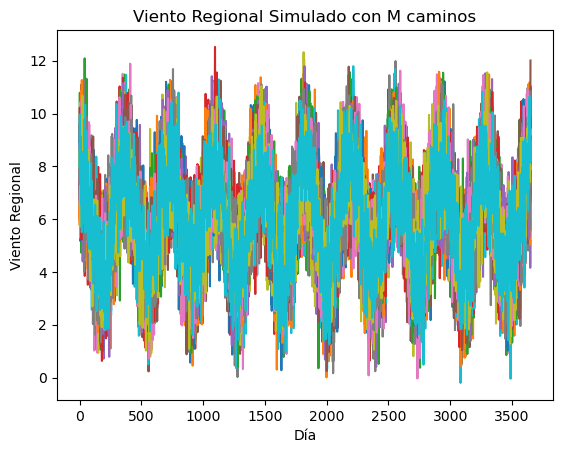

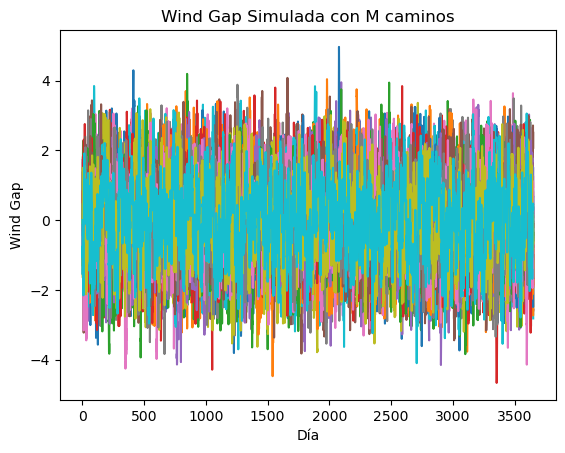

In [69]:
# Función para simular caminos de viento
def wind_paths(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T, M):
    S = np.full((M, T), S_0)
    D = np.full((M, T), D_0)
    for j in range (M):
        for t in range(1, T):
            Z = np.random.normal(0, 1)  # Shock para el viento regional
            W = np.random.normal(0, 1)  # Shock para la diferencia de viento
            
            # Evolución del viento regional
            S[j][t] = S[j][t-1] + kappa * (theta[t] - S[j][t-1]) * delta + np.sqrt(delta) * Z * sigma
            
            # Evolución de la diferencia de viento entre Norte y Sur
            D[j][t] = D[j][t-1] - (beta * D[j][t-1] * delta) + gamma * np.sqrt(delta) * W

    return S, D

# Inicialización de parámetros
S_0 = data['regional wind'].iloc[0]
D_0 = data['wind gap norte sur'].iloc[0]
T = len(data)  # Usamos el mismo número de días que en los datos históricos
delta = 1 / 365  
M = 30

# Simulamos
S, D = wind_paths(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T, M)

# Calculamos viento en Norte y Sur
viento_norte = S - D / 2
viento_sur = S + D / 2

#Calculamos viento historico norte y sur
viento_norte_historico = data['regional wind'] - data['wind gap norte sur'] / 2
viento_sur_historico = data['regional wind'] + data['wind gap norte sur'] / 2

for S_i in S :
  plt.plot(S_i)
  plt.title('Viento Regional Simulado con M caminos')
  plt.xlabel('Día')
  plt.ylabel('Viento Regional')

plt.show()

for D_i in D :
  plt.plot(D_i)
  plt.title('Wind Gap Simulada con M caminos')
  plt.xlabel('Día')
  plt.ylabel('Wind Gap')

plt.show()




Hacemos un función para calcular el Cashflow (eligiendo un umbral K) para luego calcular el VAN:

# Ejercicio 3 y 4
Realizamos las simulaciones de los dos molinos, para luego calcular su cashflow y su VAN:

In [70]:
def simulate_molino(S, K, T):
    cash_flow = np.zeros(T)
    roturas = np.zeros(T)
    estados = np.zeros(T)
    estado = 'apagado'
    roto = False
    apagados = np.zeros(T)
    encendidos = np.zeros(T)
    for t in range(0, T):
        if estado == 'encendido':
            prob_falla = 0.25 * (S[t] ** 2) * delta
            if np.random.random() < prob_falla:
                roto = True  # El molino se rompe
                roturas[t]=1
        if roto:
            cash_flow[t] = -200000  # Costo de reparación
            roto = False  # Molino se repara en el mismo día
            estado = 'apagado'  # Se apaga después de repararse
            apagados[t] = 1
        else:
            if S[t] > K and estado == 'encendido':
                cash_flow[t] = -1000  # Costo de apagar
                estado = 'apagado'
                apagados[t] = 1

            elif S[t] <= K and estado == 'apagado':
                cash_flow[t] = 1000 * S[t]  # Encender no cuesta nada
                estado = 'encendido'
                encendidos[t] = 1
                
            if estado == 'encendido':
                ingreso_diario = 1000 * S[t]
                cash_flow[t] = ingreso_diario
        
        if estado == 'apagado':
            estados[t] = 1
        
    return cash_flow, roturas, encendidos, apagados, estados

# Parámetros iniciales
S_0 = data['regional wind'].iloc[0]
D_0 = data['wind gap norte sur'].iloc[0]
T = 365
delta = 1 / 365

# Simulación de viento
S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)
viento_norte = S - (D / 2) # Generamos Viento Norte
viento_sur = S + (D / 2) # Generamos Viento Sur

# Parámetros de operación
K = 7.75 # Umbral de velocidad de viento para apagar el molino


# Simulación de ganancias de molinos Norte y Sur
cash_flow_norte, roturas_norte, encendidos_norte, apagados_norte, estados_norte = simulate_molino(viento_norte, K, T)
cash_flow_sur, roturas_sur, encendidos_sur, apagados_sur, estados_sur  = simulate_molino(viento_sur, K, T)


# Cálculo del Valor Actual Neto (VAN)
tasa_interes = 0.05
def calcular_van(cash_flows, tasa_interes, T):
    descuento = np.exp(-tasa_interes * np.arange(T) / 365)
    VAN = np.sum(cash_flows * descuento)
    return VAN

# Resultados
VAN_norte = calcular_van(cash_flow_norte, tasa_interes, T)
VAN_sur = calcular_van(cash_flow_sur, tasa_interes, T)
print(f"VAN del Molino Norte: {VAN_norte:.2f} USD")
print(f"VAN del Molino Sur: {VAN_sur:.2f} USD")

VAN del Molino Norte: 975512.96 USD
VAN del Molino Sur: 93558.50 USD


# Gráficos Molino Norte: 
## 1er Gráfico: Evolución del viento, roturas y diferentes decisiones de prendido y apagado a lo largo de los días.

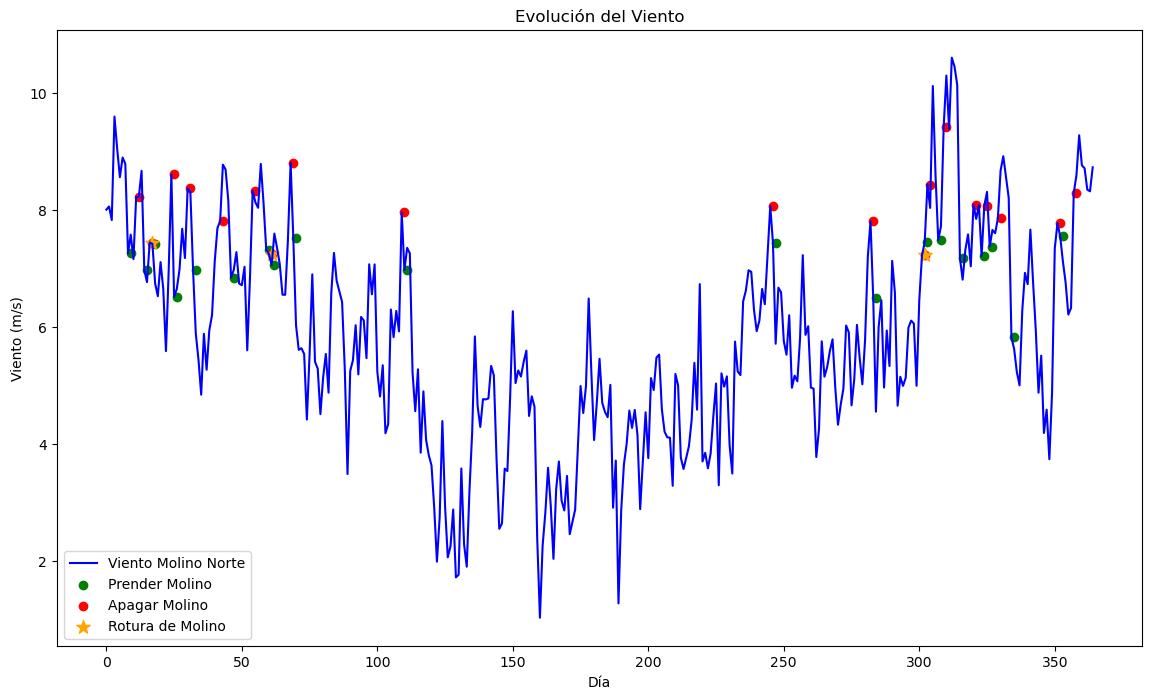

In [71]:
# Gráfico de la evolución del viento con roturas
plt.figure(figsize=(14, 8))
plt.plot(viento_norte,label='Viento Molino Norte', color='blue')
# Añadir puntos en los días en que se prendió el molino
dias_con_molino_norte = [i + 1 for i in range(len(encendidos_norte)) if encendidos_norte[i] == 1]
viento_con_encendidos_norte = [viento_norte[i] for i in range(len(encendidos_norte)) if encendidos_norte[i] == 1]
# Añadir puntos en los días en que se apagó el molino
dias_apagado_norte = [i + 1 for i in range(len(apagados_norte)) if apagados_norte[i] == 1]
viento_con_apagados_norte = [viento_norte[i] for i in range(len(apagados_norte)) if apagados_norte[i] == 1]
# Añadir puntos en los días en que se rompió el molino
dias_rotura_norte = [i + 1 for i in range(len(roturas_norte)) if roturas_norte[i] == 1]
viento_con_roturas_norte = [viento_norte[i] for i in range(len(roturas_norte)) if roturas_norte[i] == 1]


plt.scatter(dias_con_molino_norte, viento_con_encendidos_norte, color='green', label='Prender Molino')
plt.scatter(dias_apagado_norte, viento_con_apagados_norte, color='red', label='Apagar Molino')
plt.scatter(dias_rotura_norte, viento_con_roturas_norte, color='orange', label='Rotura de Molino', marker='*',s=100)
plt.title('Evolución del Viento')
plt.xlabel('Día')
plt.ylabel('Viento (m/s)')
plt.legend()
plt.show()


## 2ndo Gráfico: Evolución de la acumulación del cashflow a lo largo de los días, en conjunto con los días que se rompió el molino.

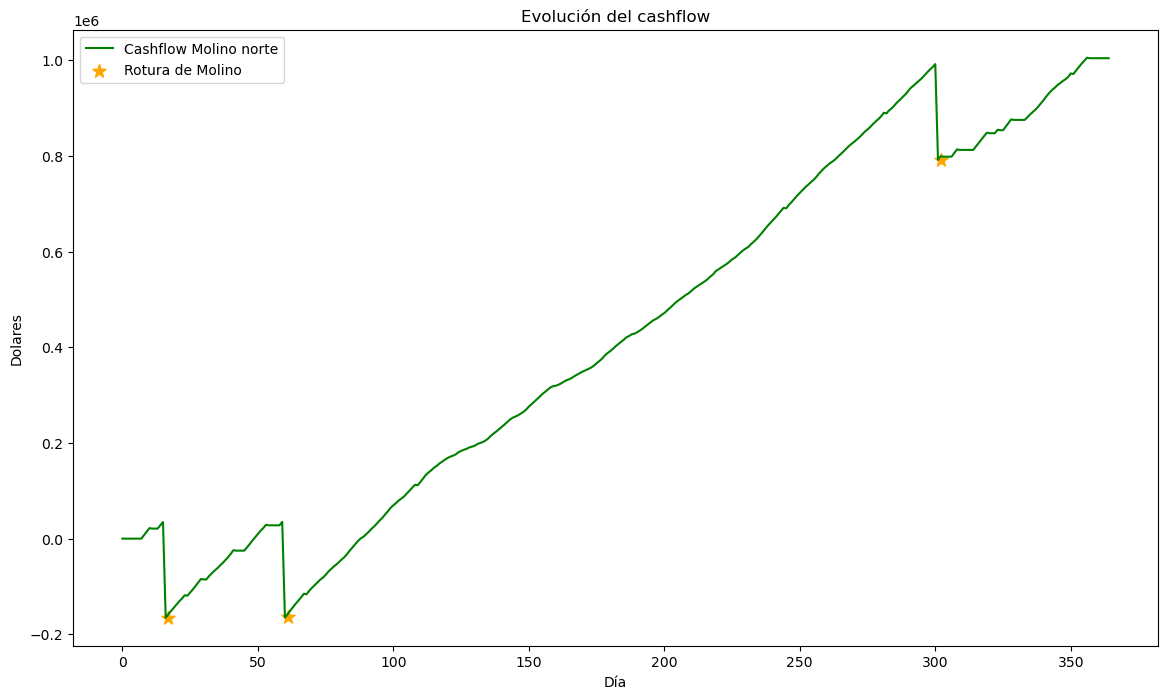

In [72]:
evo_cash_norte = np.cumsum(cash_flow_norte)
# Gráfico de la evolución del viento con roturas
plt.figure(figsize=(14, 8))
plt.plot(evo_cash_norte,label='Cashflow Molino norte', color='green')
# Añadir puntos en los días en que se rompió el molino
roturas_cashflow_norte = [evo_cash_norte[i] for i in range(len(roturas_norte)) if roturas_norte[i] == 1]
plt.scatter(dias_rotura_norte, roturas_cashflow_norte, color='orange', label='Rotura de Molino', marker='*',s=100)
plt.title('Evolución del cashflow')
plt.xlabel('Día')
plt.ylabel('Dolares')
plt.legend()
plt.show()


# Gráficos Molino Sur: 
## 1er Gráfico: Evolución del viento, roturas y diferentes decisiones de prendido y apagado a lo largo de los días.

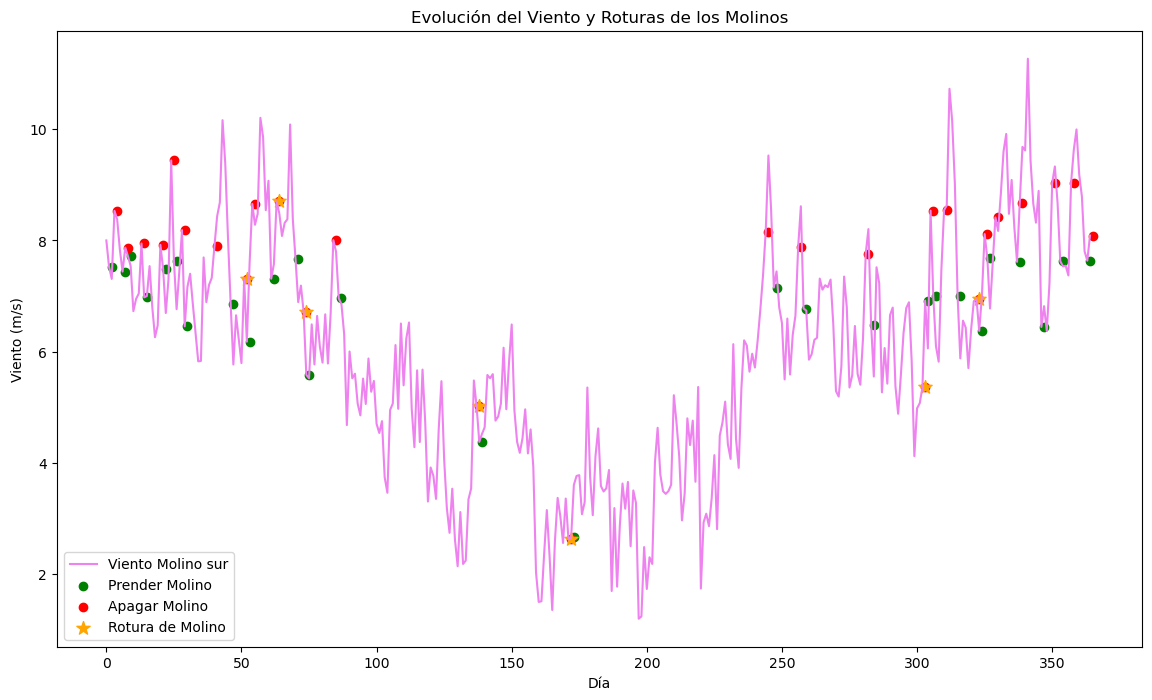

In [73]:
# Gráfico de la evolución del viento con roturas
plt.figure(figsize=(14, 8))
plt.plot(viento_sur,label='Viento Molino sur', color='violet')
# Añadir puntos en los días en que se prendió el molino
dias_con_molino_sur = [i + 1 for i in range(len(encendidos_sur)) if encendidos_sur[i] == 1]
viento_con_encendidos_sur = [viento_sur[i] for i in range(len(encendidos_sur)) if encendidos_sur[i] == 1]
# Añadir puntos en los días en que se apagó el molino
dias_apagado_sur = [i + 1 for i in range(len(apagados_sur)) if apagados_sur[i] == 1]
viento_con_apagados_sur = [viento_sur[i] for i in range(len(apagados_sur)) if apagados_sur[i] == 1]
# Añadir puntos en los días en que se rompió el molino
dias_rotura_sur = [i + 1 for i in range(len(roturas_sur)) if roturas_sur[i] == 1]
viento_con_roturas_sur = [viento_sur[i] for i in range(len(roturas_sur)) if roturas_sur[i] == 1]


plt.scatter(dias_con_molino_sur, viento_con_encendidos_sur, color='green', label='Prender Molino')
plt.scatter(dias_apagado_sur, viento_con_apagados_sur, color='red', label='Apagar Molino')
plt.scatter(dias_rotura_sur, viento_con_roturas_sur, color='orange', label='Rotura de Molino', marker='*',s=100)
plt.title('Evolución del Viento y Roturas de los Molinos')
plt.xlabel('Día')
plt.ylabel('Viento (m/s)')
plt.legend()
plt.show()

## 2ndo Gráfico: Evolución de la acumulación del cashflow a lo largo de los días, en conjunto con los días que se rompió el molino.

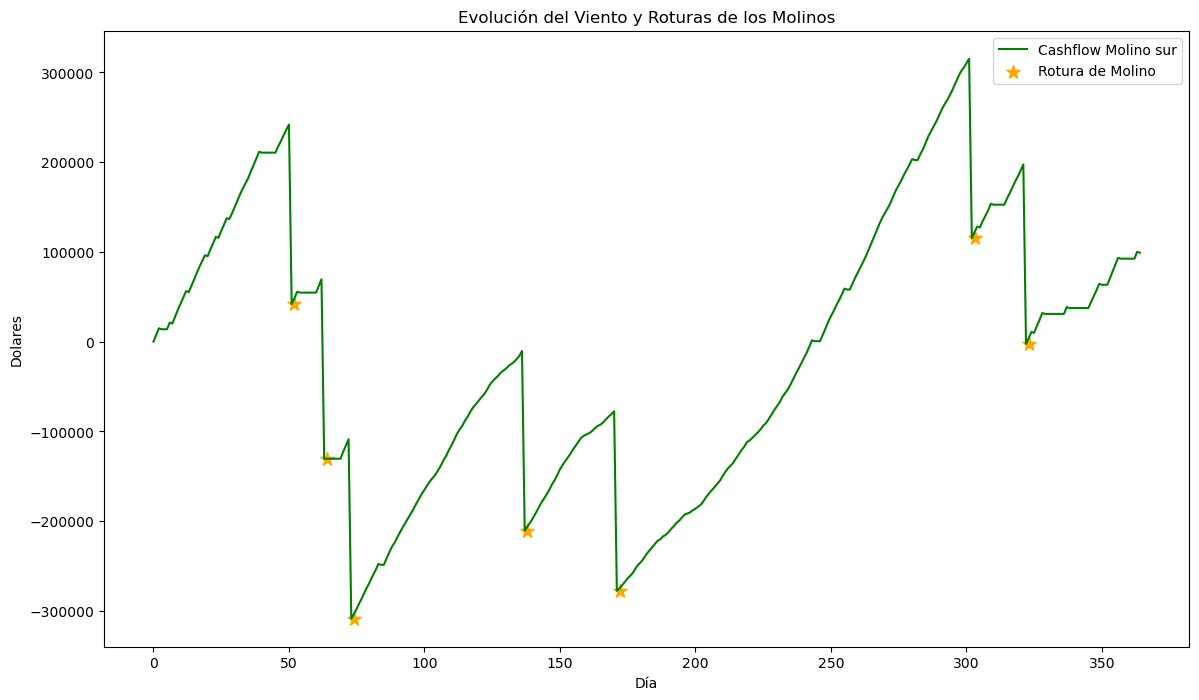

In [74]:
evo_cash_sur = np.cumsum(cash_flow_sur)
# Gráfico de la evolución del viento con roturas
plt.figure(figsize=(14, 8))
plt.plot(evo_cash_sur,label='Cashflow Molino sur', color='green')
# Añadir puntos en los días en que se rompió el molino
roturas_cashflow_sur = [evo_cash_sur[i] for i in range(len(roturas_sur)) if roturas_sur[i] == 1]
plt.scatter(dias_rotura_sur, roturas_cashflow_sur, color='orange', label='Rotura de Molino', marker='*', s=100)
plt.title('Evolución del Viento y Roturas de los Molinos')
plt.xlabel('Día')
plt.ylabel('Dolares')
plt.legend()
plt.show()

# Ejercicio 5

In [75]:
# Función para encontrar el umbral óptimo de K
def VAN_estimado_k(num_simulaciones=10000, K=9):  # Inicializa el mejor K como None
    van_total = 0
    van_lista = []
    for i in range(num_simulaciones):
        S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)
        cash_flow_norte, _, _, _, _ = simulate_molino(S + D / 2, K, T)
        cash_flow_sur, _, _, _, _= simulate_molino(S - D / 2, K, T)
        cash_flow_total = cash_flow_norte + cash_flow_sur
        van = calcular_van(cash_flow_total, tasa_interes, T)  # Calcula el VAN del cash flow total
        van_total = van_total + van
        van_lista.append(van)
    van_total = van_total / num_simulaciones
    return van_total, np.std(van_lista)

# Ejecutar la función
van_K, std_van_K = VAN_estimado_k(num_simulaciones=1000, K=9)

# Mostrar resultados
print(f"El VAN promedio es: {van_K:.2f} USD")
print(f"El Error estándar  es: {std_van_K:.2f} USD")


El VAN promedio es: 471152.35 USD
El Error estándar  es: 779089.73 USD


# Ejercicio 6:

buscamo k optimo

In [76]:
# Función para encontrar el umbral óptimo de K
def k_optimo(num_simulaciones=1000):
    k_max = None  # Inicializa el mejor K como None
    van_max = - np.inf  # Inicializa el VAN máximo como un valor muy bajo
    for k in np.arange(1, 13, 0.25):
        van_total = 0
        for i in range(num_simulaciones):
            S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)
            cash_flow_norte, _, _, _ , _= simulate_molino(S + D / 2, k, T)
            cash_flow_sur, _, _, _, _= simulate_molino(S - D / 2, k, T)
            cash_flow_total = cash_flow_norte + cash_flow_sur
            van = calcular_van(cash_flow_total, tasa_interes, T)  # Calcula el VAN del cash flow total
            van_total = van_total + van
        van_total = van_total / num_simulaciones
        if van_total > van_max:  # Compara el VAN calculado con el máximo anterior
            van_max = van_total
            k_max = k
        

    return k_max, van_total

# Ejecutar la función
k_max, van_promedio = k_optimo(num_simulaciones=1000)

# Mostrar resultados
print(f"El umbral K óptimo promedio es: {k_max}")
print(f"El VAN promedio es: {van_promedio:.2f} USD")


KeyboardInterrupt: 

# Ejercicio 7:

Opción ingenua vs la nuestra

In [77]:
# Opción Ingenua -> Elegimos un K muy alto, por lo que nunca vamos a apagar los molinos

# Ejecutar la función con K = 30 (nunca llega)
van_K, std_van_K = VAN_estimado_k(num_simulaciones=1000, K=30)
print(f"El VAN promedio es: {van_K:.2f} USD con método ingenuo")
print(f"El Error estándar  es: {std_van_K:.2f} USD con método ingenuo")


# Ejecutar la función con K = 7.75
van_K, std_van_K = VAN_estimado_k(num_simulaciones=1000, K=7.75)
print(f"El VAN promedio es: {van_K:.2f} USD con K óptimo")
print(f"El Error estándar  es: {std_van_K:.2f} USD con K óptimo")

El VAN promedio es: 468879.48 USD con método ingenuo
El Error estándar  es: 823518.21 USD con método ingenuo
El VAN promedio es: 509485.33 USD con K óptimo
El Error estándar  es: 687332.37 USD con K óptimo


# Ejercicio 8


### Acá la idea es simular el viento y solo tomar los días correspondientes a Agosto, son del día 244 al 274 y tomar el ingreso que hubo en ese mes, plotear la distribución del ingreso en ese mes

El estimación del ingreso de un dia de agosto es: 2164.32 USD
El desvio estándar es: 40352.57 USD
La varianza es: 1628330042.71 USD
Cuantiles:
 0.25     8350.794882
0.50    10316.798851
0.75    11922.945197
dtype: float64


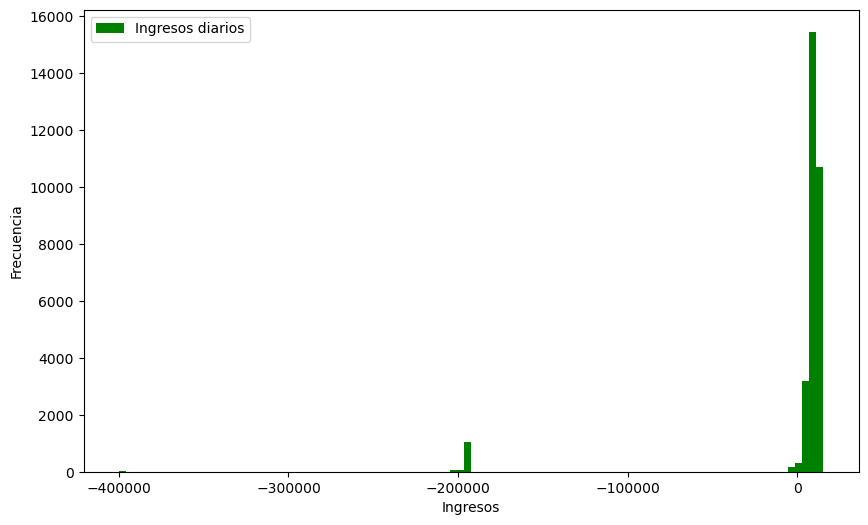

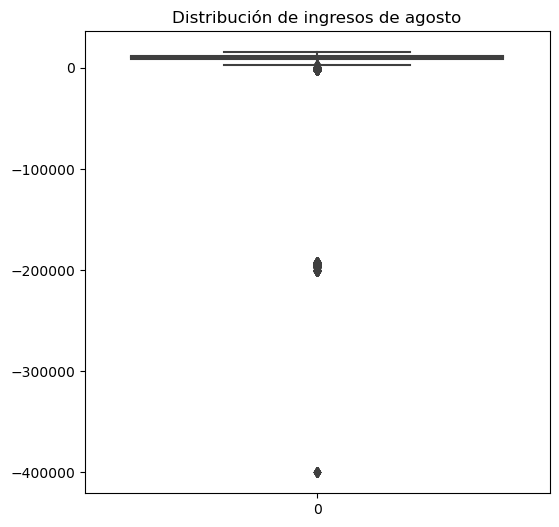

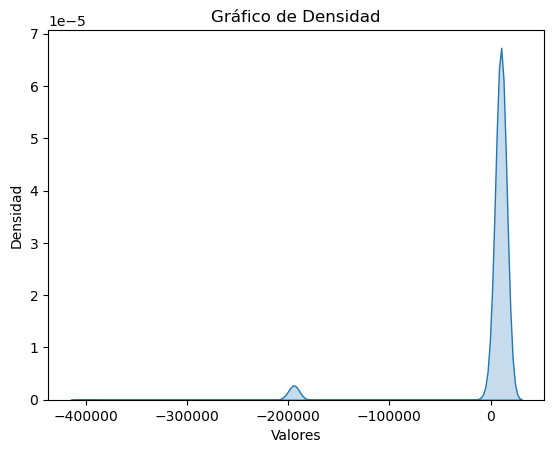

In [78]:
def ingresos_agosto(k_optimo, T=365):
    ingresos = []
    np.random.seed(244)
    for _ in range(1000):
        S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)
        cash_flow_norte, _, _, _, _ = simulate_molino(S + D / 2, k_optimo, T)
        cash_flow_sur, _, _, _, _= simulate_molino(S - D / 2, k_optimo, T)
        cash_flow_total = cash_flow_norte + cash_flow_sur
        ingresos_agosto = cash_flow_total[244:275]  # Agosto es del día 244 al 275
        ingresos.append(ingresos_agosto)
    
    # suma_ingresos = np.sum(ingresos, axis=0)
    # ingresos_final = suma_ingresos / 1000
    ingresos = [numero for sublista in ingresos for numero in sublista]

    return ingresos

ingresos_agosto = ingresos_agosto(7.75)

varianza_agosto = np.var(ingresos_agosto)
desvio_agosto = np.std(ingresos_agosto)
estimacion_agosto = np.mean(ingresos_agosto)

print(f"El estimación del ingreso de un dia de agosto es: {estimacion_agosto:.2f} USD")
print(f"El desvio estándar es: {desvio_agosto:.2f} USD")
print(f"La varianza es: {varianza_agosto:.2f} USD")

serie = pd.Series(ingresos_agosto)
cuantiles = serie.quantile([0.25, 0.5, 0.75])
print("Cuantiles:\n", cuantiles)


plt.figure(figsize=(10, 6))
plt.hist(ingresos_agosto, bins = 100, color='g', label='Ingresos diarios')
plt.xlabel('Ingresos')
plt.ylabel('Frecuencia')
plt.title('')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
sns.boxplot(ingresos_agosto)
plt.title('Distribución de ingresos de agosto')
plt.show()

sns.kdeplot(serie, fill=True)
plt.title('Gráfico de Densidad')
plt.xlabel('Valores')
plt.ylabel('Densidad')
plt.show()


# Ejercicio 9

### Bueno aca lo mismo que siempre, es simular el viento con el umbral K óptimo (estrategia óptima) y simular el viento sin umbral o un K muy alto que el viento nunca va a llegar a tal velocidad (estrategia no apagar)

In [79]:
# Función para encontrar  numero medio de roturas por ano
def roturas_media(num_simulaciones=10000, K=9):  
    np.random.seed(244)
    roturas_total = 0
    roturas_norte_total = 0 
    roturas_sur_total = 0
    for i in range(num_simulaciones):
        S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)
        _, roturas_norte, _, _, _ = simulate_molino(S + D / 2, K, T)
        _, roturas_sur, _, _, _= simulate_molino(S - D / 2, K, T)
        roturas_norte = sum(roturas_norte)
        roturas_sur = sum(roturas_sur)
        roturas_total += roturas_norte + roturas_sur
        roturas_norte_total += roturas_norte
        roturas_sur_total += roturas_sur
    media_rotura_norte = roturas_norte_total / num_simulaciones
    media_rotura_sur = roturas_sur_total / num_simulaciones
    media_rotura_total = roturas_total / num_simulaciones

    return media_rotura_norte, media_rotura_sur, media_rotura_total



media_rotura_norte, media_rotura_sur, media_rotura_total = roturas_media(num_simulaciones=1000, K=7.5)
print(f"El número medio de roturas del molino norte es: {media_rotura_norte:.2f} veces al año con el K óptimo")
print(f"El número medio de roturas del molino sur es: {media_rotura_sur:.2f} veces al año con el K óptimo")
print(f"El número medio de roturas de ambos molinos es: {media_rotura_total:.2f} veces al año con el K óptimo")


media_rotura_norte, media_rotura_sur, media_rotura_total = roturas_media(num_simulaciones=1000, K=30)
print(f"El número medio de roturas del molino norte es: {media_rotura_norte:.2f} veces al año sin apagar el molino")
print(f"El número medio de roturas del molino sur es: {media_rotura_sur:.2f} veces al año sin apagar el molino")
print(f"El número medio de roturas de ambos molinos es: {media_rotura_total:.2f} veces al año sin apagar el molino")


El número medio de roturas del molino norte es: 5.71 veces al año con el K óptimo
El número medio de roturas del molino sur es: 5.68 veces al año con el K óptimo
El número medio de roturas de ambos molinos es: 11.39 veces al año con el K óptimo
El número medio de roturas del molino norte es: 9.48 veces al año sin apagar el molino
El número medio de roturas del molino sur es: 9.60 veces al año sin apagar el molino
El número medio de roturas de ambos molinos es: 19.08 veces al año sin apagar el molino


# Ejercicio 10


Bajo la estrategia óptima, cuál es el número de días por año en los que cada molino está inactivo en promedio, ya sea por apagado voluntario o rotura?

In [80]:
# Función para encontrar  numero medio de roturas por ano
def inactividad_media(num_simulaciones=10000, K=9):  
    np.random.seed(244)
    inactividad_norte_total = 0 
    inactividad_sur_total = 0
    for i in range(num_simulaciones):
        S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)
        _, _, _, _, estados_norte = simulate_molino(S + D / 2, K, T)
        _, _, _, _, estados_sur= simulate_molino(S - D / 2, K, T)
        estados_norte = sum(estados_norte)
        estados_sur = sum(estados_sur)
        inactividad_norte_total += estados_norte
        inactividad_sur_total += estados_sur
    media_inactivo_norte = inactividad_norte_total / num_simulaciones
    media_inactivo_sur = inactividad_sur_total / num_simulaciones

    return media_inactivo_norte, media_inactivo_sur

media_inactivo_norte, media_inactivo_sur = inactividad_media(num_simulaciones=1000, K=7.5)
print(f"La media de días de inactividad del molino norte es: {media_inactivo_norte:.2f} días al año con el K óptimo")
print(f"La media de días de inactividad del molino sur es: {media_inactivo_sur:.2f} días al año con el K óptimo")

La media de días de inactividad del molino norte es: 90.18 días al año con el K óptimo
La media de días de inactividad del molino sur es: 89.99 días al año con el K óptimo


# Ejercicio 11

Acá si CREO que tenemos que usar la formula q vimos en clase:

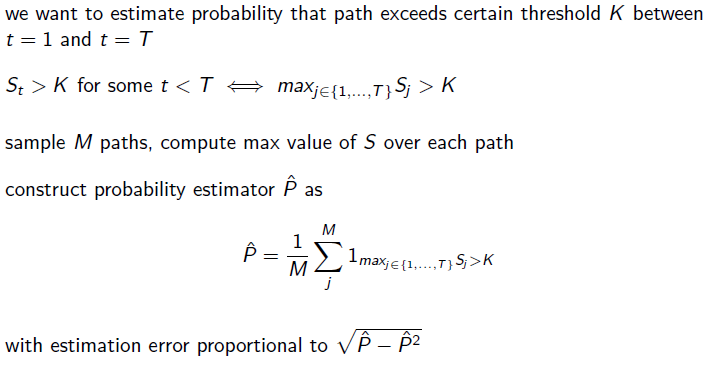

Simular, ver si supera K, y ver si tanto norte como sur estan inactivos (9 de julio, t=190)

Y para algun dia del año creo q es simplemente modificar el t

AGREGAR EL ERROR: sqrt(p-(p**2))

In [90]:
def inactividad_julio(k_optimo, T=365, num_simulaciones=10000):
    inactividad_norte_suma = 0
    inactividad_sur_suma = 0
    inactividad_comun = 0
    for _ in range(num_simulaciones):
        S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)
        _, _, _, _, inactividad_norte = simulate_molino(S + D / 2, k_optimo, T)
        _, _, _, _, inactividad_sur= simulate_molino(S - D / 2, k_optimo, T)

        if inactividad_norte[189]== 1 and inactividad_sur[189]==1 : 
            inactividad_comun += 1
    
    inactividad_comun_media = inactividad_comun / num_simulaciones
    return inactividad_comun_media

inactividad_9_julio = inactividad_julio(7.75)
print(f"La probabilidad de que los dos molinos estén inactivos el 9 de julio es: {inactividad_9_julio:.5f}")

La probabilidad de que los dos molinos estén inactivos el 9 de julio es: 0.00050


In [95]:
def inactividad(k_optimo, T=365, num_simulaciones=1000):
    inactividad_total = 0
    
    for _ in range(num_simulaciones):
        S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)
        _, _, _, _, inactividad_norte = simulate_molino(S + D / 2, k_optimo, T)
        _, _, _, _, inactividad_sur = simulate_molino(S - D / 2, k_optimo, T)

        for i in range(0,365):
            inactividad_comun = 0
            if inactividad_norte[i]== 1 and inactividad_sur[i]==1 : 
                inactividad_comun += 1
        inactividad_total += inactividad_comun / 365

    inactividad_comun_media = inactividad_total / num_simulaciones
    return inactividad_comun_media

inactividad = inactividad(7.75)
print(f"La probabilidad de que los dos molinos estén inactivos algún día del año es: {inactividad:.5f}")

La probabilidad de que los dos molinos estén inactivos algún día del año es: 0.00125


In [ ]:
# Codigo boceto
T = 190
def calcular_probabilidad_inactividad(K, num_simulaciones, T):
    inactividad_simultanea_9_julio = 0
    inactividad_simultanea_anual = 0
    
    for _ in range(num_simulaciones):
        # Simular trayectorias de viento para los molinos Norte y Sur
        viento_norte = simular_viento(T)
        viento_sur = simular_viento(T)
        
        # Comprobar si los molinos están inactivos el 9 de julio (supongamos que el día 9 de julio es el día 190)
        dia_9_julio = 189
        if viento_norte[dia_9_julio] > K and viento_sur[dia_9_julio] > K:
            inactividad_simultanea_9_julio += 1
        
        # Comprobar si los molinos están inactivos en algún día del año
        if np.max(viento_norte) > K and np.max(viento_sur) > K:
            inactividad_simultanea_anual += 1

    # Calcular las probabilidades estimadas
    prob_9_julio = inactividad_simultanea_9_julio / num_simulaciones
    prob_anual = inactividad_simultanea_anual / num_simulaciones
    
    return prob_9_julio, prob_anual

# Ejercicio 12

### Acá devuelta, a partir de la simulación, calcular los ingresos que generamos en mayo, y calcular la correlación de los ingresos mensuales

    correlacion = np.corrcoef(ingresos_norte, ingresos_sur)[0, 1]
    
    return correlacion



In [97]:
def ingresos_mayo(k_optimo, T=365):
    ingresos_norte = []
    ingresos_sur = []
    np.random.seed(244)
    for _ in range(1000):
        S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)
        cash_flow_norte, _, _, _, _ = simulate_molino(S + D / 2, k_optimo, T)
        cash_flow_sur, _, _, _, _= simulate_molino(S - D / 2, k_optimo, T)
        ingresos_norte_muestra= np.sum(cash_flow_norte[120:151]) 
        ingresos_sur_muestra= np.sum(cash_flow_sur[120:151])
        ingresos_norte.append(ingresos_norte_muestra)
        ingresos_sur.append(ingresos_sur_muestra)
    
    correlacion = np.corrcoef(ingresos_norte, ingresos_sur)[0, 1]
    
    return correlacion

correlacion = ingresos_mayo(7.75)
print(correlacion)

0.03342723996262256


# Ejercicio 13

### Bueno acá es volver a simular solo cambiando el costo de reparación a -250.000, recalcular el van, y volver a calcular el umbral K óptimo y comparar como cambia

# Ejercicio 14


### Acá lo que creo q hay que hacer es modificar el viento de los csv por +10%, -10% etc, crear CSVs aparte y de ahi volver a simular viento, calcular vany calcular umbral K óptimo